# setup

In [1]:
import os, re, json, glob, math, sys, random
from pathlib import Path
from typing import Dict, Iterable, Optional, Sequence, Tuple, Set
from collections import defaultdict, Counter, deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, ScalarFormatter

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# ----------------------------
# Project root (repo)
# ----------------------------
#PROJ_ROOT = Path("/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/OTU-TAXA-FOUNDATION").resolve()
PROJ_ROOT = Path("/home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation")
SRC_DIR = PROJ_ROOT / "src"

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# ----------------------------
# Local package imports (src/otu_taxa)
# ----------------------------
from otu_taxa.dataloaders_unk_balanced import (
    OTUTaxaDataset,
    MaskingConfig,
    make_tax_only_mask_collator,
)

# If you still use these helper functions in your old test notebook,
# keep them. Otherwise we can remove later.
from otu_taxa.helpers_taxa_prediction import (
    load_vocab_json,
    norm_id,
    parse_tax_to_cols,
    is_unknown,
    evaluate_and_plot_predictions,
)

# UNK-aware metrics / decoding helpers
from otu_taxa.joint_hier_loss_metrics_unk import (
    hierarchical_predict_full_path,
    make_factorized_tax_loss_fn_fast_masked_with_unk,
    get_tax_path_for_label,
    deepest_taxonomy_accuracy_f1,   # often useful in testing
)

# UNK-aware model
from otu_taxa.otu_taxa_transformer_unk import (
    ModelConfig,
    OTUTaxaTransformerEmbedTaxTreeUnkTaxa,
)
from otu_taxa.helpers_pretraining_model import IGNORE_INDEX, set_seed




# load Model

In [2]:
# ---------------------------
# Run paths (inside repo)
# ---------------------------
run_name = "pretrain_hier_joint_unk_taxa"
RUN_DIR   = os.path.join(PROJ_ROOT, "runs_microbeatlas", run_name)
META_PATH = os.path.join(RUN_DIR, "meta.json")
CKPT_PATH = os.path.join(RUN_DIR, "best.pt")

with open(META_PATH, "r") as f:
    meta = json.load(f)

# ---------------------------
# External (heavy) dataset location (outside repo)
# Use EXACT same path construction as training
# ---------------------------
DATASET_ROOT = "/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training"
dataset_folder_name = meta.get("dataset_folder_name", "dataset_full_top999")  # prefer meta if saved

dataset_dir = os.path.join(
    DATASET_ROOT,
    "level_97",
    "silva-138.2",
    "incomplete_silva_sintax",
    dataset_folder_name,
)

SAMPLES_JSONL = os.path.join(dataset_dir, "samples.jsonl")
TREE_DIR = os.path.join(dataset_dir, "tree_artifacts")

assert os.path.isfile(SAMPLES_JSONL), f"Missing samples.jsonl: {SAMPLES_JSONL}"
assert os.path.isdir(TREE_DIR), f"Missing tree_artifacts dir: {TREE_DIR}"

print("[INFO] dataset_dir:", dataset_dir)

[INFO] dataset_dir: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999


In [3]:

# ---------------------------
# Rebuild EXACT split used in training
# ---------------------------
# Preferred: read from meta if you saved them; fallback to your hardcoded training constants.
seed   = meta.get("seed", 123)
TEST_N = meta.get("TEST_N", 20_000)
VAL_N  = meta.get("VAL_N", 20_000)

set_seed(seed)
random.seed(seed)

ds = OTUTaxaDataset(dataset_dir)
N = len(ds)
print(f"[INFO] Dataset size: N={N}")

TEST_N = min(TEST_N, N)
VAL_N  = min(VAL_N, N - TEST_N)

all_idx = list(range(N))
random.shuffle(all_idx)

test_idx  = sorted(all_idx[:TEST_N])
val_idx   = sorted(all_idx[TEST_N:TEST_N + VAL_N])
train_idx = sorted(all_idx[TEST_N + VAL_N:])

print(f"[SPLIT] Train={len(train_idx)}  Val={len(val_idx)}  Test={len(test_idx)}  (Total N={N})")

train_ds = Subset(ds, train_idx)
val_ds   = Subset(ds, val_idx)
test_ds  = Subset(ds, test_idx)


[INFO] Dataset size: N=1836250
[SPLIT] Train=1796250  Val=20000  Test=20000  (Total N=1836250)


In [4]:
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"

# ---------------------------
# Experiment & run names (NEW layout)
# ---------------------------
run_name = "pretrain_hier_joint_unk_taxa"
experiment_name = "runs_microbeatlas"     # in your screenshot, run dir is runs_microbeatlas/<run_name>

RUN_DIR   = os.path.join(PROJ_ROOT, experiment_name, run_name)
CKPT_PATH = os.path.join(RUN_DIR, "best.pt")
META_PATH = os.path.join(RUN_DIR, "meta.json")

# ---------------------------
# Full MicrobeAtlas dataset path (EXACT training logic)
# ---------------------------
DATASET_ROOT = "/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training"
dataset_folder_name = "dataset_full_top999"

dataset_dir = os.path.join(
    DATASET_ROOT,
    "level_97",
    "silva-138.2",
    "incomplete_silva_sintax",
    dataset_folder_name,
)

TREE_DIR = os.path.join(dataset_dir, "tree_artifacts")
UNK_VOCAB_PATH = os.path.join(TREE_DIR, "taxonomy_vocab_with_unk.json")
UNK_M_PATH     = os.path.join(TREE_DIR, "descendant_matrix_with_unk.npy")
RANK_IDX_PATH  = os.path.join(TREE_DIR, "rank_idx.npy")

# ---------------------------
# Output location for predictions (NEW)
# Put outputs under the dataset folder, similar to old code, but different experiment_name
# ---------------------------
OUT_DIR = Path(dataset_dir) / "predictions_of_taxa" / experiment_name / run_name
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_JSONL = OUT_DIR / "pred_affected_taxonomy.jsonl"

# ---------------------------
# 1) meta.json strict load
# ---------------------------
with open(META_PATH, "r") as f:
    meta = json.load(f)

mc = meta.get("model_cfg")
if mc is None:
    raise KeyError("meta.json must contain 'model_cfg'.")

# strict minimal model config check (adjust if your ModelConfig has different fields)
required_mc = ["d_model", "n_layers", "n_heads", "d_ff", "dropout", "activation"]
missing = [k for k in required_mc if k not in mc]
if missing:
    raise KeyError(f"meta['model_cfg'] missing required keys: {missing}")

# ---------------------------
# 2) dataset sizes + strict consistency checks
# ---------------------------
ds = OTUTaxaDataset(dataset_dir)
O_ds = ds.O
T_real_ds = ds.T

ds_meta = meta.get("dataset", {})
if not ds_meta:
    raise KeyError("meta.json must contain 'dataset' with O/T info.")

mO     = ds_meta.get("O")
T_real = ds_meta.get("T_real")
T_base = ds_meta.get("T_base")

if mO is None or T_real is None or T_base is None:
    raise KeyError("meta['dataset'] must contain 'O', 'T_real', 'T_base'.")

if mO != O_ds:
    raise ValueError(f"Dataset O mismatch: meta O={mO}, dataset O={O_ds}")

if T_real != T_real_ds:
    raise ValueError(f"Dataset T_real mismatch: meta T_real={T_real}, dataset T={T_real_ds}")

# specials (exact same convention as training)
pad_otu_id  = O_ds
mask_otu_id = O_ds + 1

pad_tax_id  = T_base
mask_tax_id = T_base + 1

n_otus = O_ds + 2
n_taxa = T_base + 2

# ---------------------------
# 3) Load UNK tree artifacts required for hierarchical loss/decoding
# ---------------------------
with open(UNK_VOCAB_PATH, "r") as f:
    tax_vocab_unk = json.load(f)
if len(tax_vocab_unk) != T_base:
    raise ValueError(f"UNK vocab length mismatch: len(vocab_unk)={len(tax_vocab_unk)} vs T_base={T_base}")



M_np = np.load(UNK_M_PATH)  # [T_base, T_base]
if M_np.shape != (T_base, T_base):
    raise ValueError(f"Descendant matrix shape mismatch: {M_np.shape} vs expected {(T_base, T_base)}")

rank_idx = np.load(RANK_IDX_PATH)  # [T_base]
if rank_idx.shape[0] != T_base:
    raise ValueError(f"rank_idx length mismatch: {rank_idx.shape} vs T_base={T_base}")

M_tensor = torch.from_numpy(M_np).to(DEVICE)
rank_idx_t = torch.from_numpy(rank_idx).to(DEVICE)

# ---------------------------
# 4) Build loss fn (keeps model construction identical to training)
# ---------------------------
hier_tax_loss_fn = make_factorized_tax_loss_fn_fast_masked_with_unk(
    M_tensor=M_tensor,
    rank_idx=rank_idx_t,
    tax_vocab=tax_vocab_unk,
    T_base=T_base,
)

# ---------------------------
# 5) Instantiate model exactly and strict checkpoint load
# ---------------------------
cfg = ModelConfig(**mc)

model = OTUTaxaTransformerEmbedTaxTreeUnkTaxa(
    n_otus=n_otus,
    n_taxa=n_taxa,
    pad_otu_id=pad_otu_id,
    pad_tax_id=pad_tax_id,
    config=cfg,
    tax_loss_fn=hier_tax_loss_fn,   # IMPORTANT for parity with training
)

raw = torch.load(CKPT_PATH, map_location="cpu")
if not isinstance(raw, dict):
    raise TypeError("Checkpoint must be a dict-like object.")

if "model" in raw and isinstance(raw["model"], dict):
    sd = raw["model"]
elif "state_dict" in raw and isinstance(raw["state_dict"], dict):
    sd = raw["state_dict"]
else:
    raise KeyError("Checkpoint must contain either 'model' or 'state_dict'.")

def strip_prefix_if_all(state_dict, prefix: str):
    keys = list(state_dict.keys())
    if keys and all(k.startswith(prefix) for k in keys):
        return {k[len(prefix):]: v for k, v in state_dict.items()}
    return state_dict

sd = strip_prefix_if_all(sd, "model.")
sd = strip_prefix_if_all(sd, "module.")

model.load_state_dict(sd, strict=True)
model.to(DEVICE).eval()

print("[OK] strict load succeeded; model on", DEVICE)
print(f"[INFO] dataset_dir={dataset_dir}")
print(f"[INFO] O={O_ds}, T_real={T_real}, T_base={T_base}, n_taxa={n_taxa}")
print(f"[INFO] OUT_JSONL={OUT_JSONL}")


UNK ids per rank: [6928, 6929, 6930, 6931, 6932, 6933, 6934]


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[OK] strict load succeeded; model on cuda:1
[INFO] dataset_dir=/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999
[INFO] O=62200, T_real=6929, T_base=6935, n_taxa=6937
[INFO] OUT_JSONL=/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/predictions_of_taxa/runs_microbeatlas/pretrain_hier_joint_unk_taxa/pred_affected_taxonomy.jsonl


In [5]:
# -----------------------------------
# Build tax_id2name mapping (GLOBAL)
# -----------------------------------
# taxonomy_vocab_with_unk.json can be either:
#   - list[str]          (index = tax_id)
#   - dict[str/int -> str]

if isinstance(tax_vocab_unk, list):
    tax_id2name = {i: name for i, name in enumerate(tax_vocab_unk)}

elif isinstance(tax_vocab_unk, dict):
    # ensure integer keys
    tax_id2name = {int(k): v for k, v in tax_vocab_unk.items()}

else:
    raise TypeError(
        f"Unsupported taxonomy vocab type: {type(tax_vocab_unk)}"
    )

# strict sanity check
if len(tax_id2name) != T_base:
    raise ValueError(
        f"tax_id2name size mismatch: "
        f"len={len(tax_id2name)} vs T_base={T_base}"
    )

print(f"[INFO] tax_id2name created (size={len(tax_id2name)})")
print(f"[INFO] preview taxonomy names: {[tax_id2name[i] for i in range(min(5, T_base))]}")

[INFO] tax_id2name created (size=6935)
[INFO] preview taxonomy names: ['c:028H05-P-BN-P5', 'c:055B07-P-DI-P58', 'c:113B434', 'c:AB64A-17', 'c:AEGEAN-245']


# Predictions

In [ ]:
# ---------------------------------------------------------
# 0) Reproducibility for the OTU selection step
# ---------------------------------------------------------
seed = meta.get("seed", 123)
random.seed(seed)

# ---------------------------------------------------------
# 1) OTU vocab mappings (NEW: use dataset artifacts, not glob)
# ---------------------------------------------------------
# In the full MicrobeAtlas pipeline, OTU vocab is usually stored in tree_artifacts or dataset_dir.
# If OTUTaxaDataset exposes id->name mappings, prefer that. Otherwise load a JSON you know.
# Below: try to locate a vocab file in dataset_dir or tree_artifacts.
otu_vocab_candidates = [
    os.path.join(dataset_dir, "otu_vocab.json"),
    os.path.join(TREE_DIR, "otu_vocab.json"),
]
otu_vocab_path = next((p for p in otu_vocab_candidates if os.path.isfile(p)), None)

otu_id2name = None
otu_name2id = None
if otu_vocab_path is not None:
    with open(otu_vocab_path, "r") as f:
        otu_vocab = json.load(f)
    # accept either {id: name} or list-of-names
    if isinstance(otu_vocab, dict):
        otu_id2name = {int(k): v for k, v in otu_vocab.items()}
        otu_name2id = {v: k for k, v in otu_id2name.items()}
    elif isinstance(otu_vocab, list):
        otu_id2name = {i: n for i, n in enumerate(otu_vocab)}
        otu_name2id = {n: i for i, n in otu_id2name.items()}
    print(f"[INFO] Loaded OTU vocab: {otu_vocab_path}  (size={len(otu_id2name)})")
else:
    print("[WARN] OTU vocab json not found; proceeding without names (IDs only).")

# ---------------------------------------------------------
# 2) Sanity check dataset sizes (parity with model block)
# ---------------------------------------------------------
O_eval, T_real_eval = ds.O, ds.T
if O_eval != O_ds:
    raise ValueError(f"OTU mismatch: model block O={O_ds}, dataset O={O_eval}")
if T_real_eval != T_real:
    raise ValueError(f"T_real mismatch: model meta T_real={T_real}, dataset T={T_real_eval}")

print(f"[INFO] Eval setup: O={O_eval}, T_real={T_real_eval}, T_base={T_base}")

# ---------------------------------------------------------
# 3) Build OTU pool from test_ds (Subset) instead of restrict_ids
# ---------------------------------------------------------
def build_otu_pool_from_subset(subset_ds, otu_key="otus", probe=None, return_counts=True):
    """
    subset_ds: torch.utils.data.Subset OR any dataset yielding dicts with key otu_key
    probe: optional max #samples to scan (None = full test subset)
    return_counts: if True, also return OTU frequency Counter
    """
    pool = set()
    counts = Counter()
    n_seen = 0

    L = len(subset_ds)
    limit = L if probe is None else min(L, int(probe))

    for i in range(limit):
        rec = subset_ds[i]
        if not isinstance(rec, dict):
            continue
        otus = rec.get(otu_key, [])
        if torch.is_tensor(otus):
            otus = otus.view(-1).tolist()
        for o in otus:
            oi = int(o.item() if torch.is_tensor(o) else o)
            pool.add(oi)
            if return_counts:
                counts[oi] += 1
        n_seen += 1

    return (pool, counts, n_seen) if return_counts else (pool, n_seen)

otu_pool, otu_counts, n_seen = build_otu_pool_from_subset(test_ds, otu_key="otus", probe=None, return_counts=True)

print(f"[POOL] scanned test samples: {n_seen}")
print(f"[POOL] unique OTUs in test set: {len(otu_pool)}")
print(f"[POOL] preview OTU IDs: {sorted(list(otu_pool))[:15]}")

# ---------------------------------------------------------
# 4) Choose random OTUs to mask 
# ---------------------------------------------------------
K_MASK_OTUS = 100   # choose your number
if len(otu_pool) < K_MASK_OTUS:
    raise ValueError(f"OTU pool too small ({len(otu_pool)}) for K_MASK_OTUS={K_MASK_OTUS}")

mask_otu_ids = sorted(random.sample(list(otu_pool), K_MASK_OTUS))
print(f"[MASK] Selected {len(mask_otu_ids)} OTUs to mask (seed={seed})")
print(f"[MASK] preview: {mask_otu_ids[:20]}")

# Optional: log their frequencies in the test set (useful for interpretation)
freq_preview = [(oid, otu_counts[oid]) for oid in mask_otu_ids[:15]]
print("[MASK] frequency preview (otu_id, #test_samples_containing_it_as_token):")
print(freq_preview)

[INFO] Loaded OTU vocab: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/otu_vocab.json  (size=62200)
[INFO] Eval setup: O=62200, T_real=6929, T_base=6935
[POOL] scanned test samples: 20000
[POOL] unique OTUs in test set: 59446
[POOL] preview OTU IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[MASK] Selected 100 OTUs to mask (seed=123)
[MASK] preview: [109, 432, 822, 1392, 2087, 2410, 2502, 2878, 3404, 3434, 4583, 5419, 5721, 5749, 6087, 6698, 7071, 8290, 8870, 9339]
[MASK] frequency preview (otu_id, #test_samples_containing_it_as_token):
[(109, 351), (432, 611), (822, 15), (1392, 1320), (2087, 265), (2410, 40), (2502, 53), (2878, 164), (3404, 574), (3434, 285), (4583, 39), (5419, 52), (5721, 77), (5749, 403), (6087, 125)]


In [7]:
# 1) Descendant matrix with UNKs
if not os.path.isfile(UNK_M_PATH):
    raise FileNotFoundError(f"Missing UNK descendant matrix: {UNK_M_PATH}")

M_np = np.load(UNK_M_PATH)  # expected shape [T_base, T_base]
if M_np.shape != (T_base, T_base):
    raise ValueError(
        f"descendant_matrix_with_unk shape mismatch: "
        f"expected ({T_base}, {T_base}), got {M_np.shape}"
    )

M_tensor = torch.from_numpy(M_np)  # CPU tensor

# 2) rank_idx (global id -> rank id 0..6), generated during preprocessing
if not os.path.isfile(RANK_IDX_PATH):
    raise FileNotFoundError(f"Missing rank_idx.npy: {RANK_IDX_PATH}")

rank_idx_np = np.load(RANK_IDX_PATH)  # expected shape [T_base]
if rank_idx_np.shape[0] != T_base:
    raise ValueError(
        f"rank_idx length mismatch: expected ({T_base},), got {rank_idx_np.shape}"
    )

# Optional strict check: ensure all ranks are in {-1,0,1,2,3,4,5,6}
valid = set([-1, 0, 1, 2, 3, 4, 5, 6])
bad = sorted(set(int(x) for x in np.unique(rank_idx_np)) - valid)
if bad:
    raise ValueError(f"rank_idx contains invalid values: {bad}")

rank_idx = torch.from_numpy(rank_idx_np.astype(np.int64))  # CPU tensor, long

# 3) move once to DEVICE for inference
M_dev = M_tensor.to(DEVICE)
rank_idx_dev = rank_idx.to(DEVICE)

print(
    f"[INFO] descendant_matrix_with_unk loaded from: {UNK_M_PATH}, "
    f"shape={M_np.shape}"
)
print(
    f"[INFO] rank_idx loaded from: {RANK_IDX_PATH}, "
    f"shape={rank_idx_np.shape}, unique={sorted(set(rank_idx_np.tolist()))}"
)

[INFO] descendant_matrix_with_unk loaded from: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/tree_artifacts/descendant_matrix_with_unk.npy, shape=(6935, 6935)
[INFO] rank_idx loaded from: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/tree_artifacts/rank_idx.npy, shape=(6935,), unique=[0, 1, 2, 3, 4, 5, 6]


In [24]:
import torch

def make_otu_and_tax_mask_collator(dataset, affected_ids, *, T_base: int, max_len=None):
    O = dataset.O
    pad_otu_id, mask_otu_id = O, O + 1
    pad_tax_id, mask_tax_id = T_base, T_base + 1

    affected_ids = set(map(int, affected_ids))

    def collate(batch):
        lengths = [len(b["otus"]) for b in batch]
        L = max_len if max_len is not None else max(lengths)
        B = len(batch)

        input_otus = torch.full((B, L), pad_otu_id, dtype=torch.long)
        input_taxa = torch.full((B, L), pad_tax_id, dtype=torch.long)
        attention_mask = torch.zeros((B, L), dtype=torch.bool)

        masked_positions = []
        sample_ids = []
        true_taxa = []
        true_otus = []   # NEW

        for i, rec in enumerate(batch):
            otus = torch.tensor(rec["otus"], dtype=torch.long)
            taxa = torch.tensor(rec["taxa"], dtype=torch.long)

            L_i = min(L, len(otus))
            input_otus[i, :L_i] = otus[:L_i]
            input_taxa[i, :L_i] = taxa[:L_i]
            attention_mask[i, :L_i] = True

            aff_mask = torch.tensor(
                [int(int(x) in affected_ids) for x in otus[:L_i]],
                dtype=torch.bool
            )

            # mask both streams for the model input
            input_otus[i, :L_i][aff_mask] = mask_otu_id
            input_taxa[i, :L_i][aff_mask] = mask_tax_id

            pos_idx = torch.nonzero(aff_mask, as_tuple=False).view(-1).tolist()
            masked_positions.append(pos_idx)

            sample_ids.append(rec["sample_id"])
            true_taxa.append(rec["taxa"])  # keep original behavior
            true_otus.append(rec["otus"])  # NEW: original OTU ids

        return {
            "input_otus": input_otus,
            "input_taxa": input_taxa,
            "attention_mask": attention_mask,
            "masked_positions": masked_positions,
            "sample_ids": sample_ids,
            "true_taxa": true_taxa,
            "true_otus": true_otus,       # NEW
        }

    return collate


In [ ]:


# -------------------------
# Output
# -------------------------
PRED_DIR = Path(RUN_DIR) / "predictions"
PRED_DIR.mkdir(parents=True, exist_ok=True)

OUT_JSONL_RANDOM = PRED_DIR / "pred_random_otu_and_taxa_masked_taxonomy_per_rank.jsonl"
if OUT_JSONL_RANDOM.exists():
    OUT_JSONL_RANDOM.unlink()

print(f"[INFO] Writing random-OTU predictions to: {OUT_JSONL_RANDOM}")

RANK_LETTERS = ['k', 'p', 'c', 'o', 'f', 'g', 's']

# -------------------------
# Choose random OTUs (from previously built otu_pool)
# -------------------------
N_RANDOM = 1000
SEED = meta.get("seed", 123)
random.seed(SEED)

random_otu_ids = random.sample(sorted(list(otu_pool)), k=N_RANDOM)
random_otu_ids = set(map(int, random_otu_ids))

print(f"[RANDOM] selected {len(random_otu_ids)} random OTUs (seed={SEED}) "
      f"(preview: {sorted(list(random_otu_ids))[:15]})")

# -------------------------
# KEEP existing collator
# It must output:
#   input_otus, input_taxa, attention_mask, sample_ids, masked_positions, true_taxa
# -------------------------
# IMPORTANT: call exactly as in old notebook.
# Example (existing signature):
max_len = meta.get("max_len", 500)  # or hard-set to 500 to match training
collate = make_otu_and_tax_mask_collator(ds, random_otu_ids, T_base=T_base, max_len=500)
# If  collator requires ds_eval rather than ds, use ds (same object behind test_ds).

# -------------------------
# Batch iterator over test_ds only (new)
# Same logic: keep only samples that contain ≥1 target OTU
# -------------------------
def batch_iter_only_affected_subset(subset, batch_size: int, affected_ids: set):
    batch = []
    matched = 0

    # subset is a torch.utils.data.Subset, indexable
    for i in range(len(subset)):
        rec = subset[i]

        # include sample if it contains ≥1 target OTU
        otus = rec.get("otus", [])
        if torch.is_tensor(otus):
            otus = otus.view(-1).tolist()
        if set(map(int, otus)) & affected_ids:
            matched += 1
            batch.append(rec)
            if len(batch) == batch_size:
                yield collate(batch)
                batch.clear()

    if batch:
        yield collate(batch)

    print(f"[INFO] TEST filtering: subset size={len(subset)} | matched with ≥1 target OTU: {matched}")

# -------------------------
# Helpers for name mapping 
# -------------------------
def _tax_name(tid: int):
    # tax_id2name might be dict[int->str] OR list[str]
    if "tax_id2name" in globals() and tax_id2name is not None:
        if isinstance(tax_id2name, dict):
            return tax_id2name.get(int(tid), f"<id:{int(tid)}>")
        if isinstance(tax_id2name, list) and 0 <= tid < len(tax_id2name):
            return tax_id2name[tid]
    # fallback: try tax_vocab_unk if present
    if "tax_vocab_unk" in globals() and tax_vocab_unk is not None:
        if isinstance(tax_vocab_unk, dict):
            return tax_vocab_unk.get(str(int(tid)), tax_vocab_unk.get(int(tid), f"<id:{int(tid)}>"))
        if isinstance(tax_vocab_unk, list) and 0 <= tid < len(tax_vocab_unk):
            return tax_vocab_unk[tid]
    return f"<id:{int(tid)}>"

def _otu_name(oid: int):
    if "otu_id2name" in globals() and otu_id2name is not None:
        return otu_id2name.get(int(oid), f"<otu:{int(oid)}>")
    return f"<otu:{int(oid)}>"

# -------------------------
# Prediction loop
# -------------------------
BATCH_SIZE = 4
total_samples = 0
total_masked_positions = 0

model.eval()
with torch.no_grad():
    with open(OUT_JSONL_RANDOM, "w") as fjsonl:
        for batch in batch_iter_only_affected_subset(
            test_ds, BATCH_SIZE, random_otu_ids
        ):
            input_otus = batch["input_otus"].to(DEVICE)
            input_taxa = batch["input_taxa"].to(DEVICE)
            attn_mask  = batch["attention_mask"].to(DEVICE)

            out = model(
                input_otus=input_otus,
                input_taxa=input_taxa,
                attention_mask=attn_mask,
            )

            # locate taxonomy logits (shape [B, L, T_ext] where T_ext = T_base + 2)
            logits_tax = None
            for k in ("logits_tax", "tax_logits", "logits_taxa"):
                if isinstance(out, dict) and k in out:
                    logits_tax = out[k]
                    break
            if logits_tax is None:
                raise KeyError("Model forward output does not contain taxonomy logits.")

            # block PAD_TAX and MASK_TAX (indices T_base, T_base+1)
            # NOTE: logits last dim should be n_taxa = T_base + 2
            if pad_tax_id < logits_tax.size(-1):
                logits_tax[:, :, pad_tax_id] = float("-inf")
            if mask_tax_id < logits_tax.size(-1):
                logits_tax[:, :, mask_tax_id] = float("-inf")

            # per-sample extraction
            for bi, sid in enumerate(batch["sample_ids"]):
                pos_list = batch["masked_positions"][bi]
                if not pos_list:
                    continue
                total_samples += 1

                true_seq = batch["true_taxa"][bi]  # should be a 1D tensor/list length L

                for pos in pos_list:
                    # logits over all taxonomy tokens (incl UNKs + specials)
                    logits_vec = logits_tax[bi, pos]         # [T_ext]
                    logits_base = logits_vec[:T_base]        # [T_base] (real+UNK, no specials)

                    # hierarchical path prediction (k→…→s)
                    path_pred = hierarchical_predict_full_path(
                        logits_vec=logits_base,
                        M_tensor=M_dev,
                        rank_idx=rank_idx_dev,
                        R=7,
                    )

                    # per-rank predictions
                    pred_by_rank = {}
                    for r, ch in enumerate(RANK_LETTERS):
                        pid = path_pred.get(r, None)
                        if pid is None:
                            continue
                        pred_by_rank[ch] = {
                            "tax_id": int(pid),
                            "tax_name": _tax_name(int(pid)),
                        }

                    # true label at this position
                    true_val = true_seq[pos]
                    true_tid = int(true_val.item() if torch.is_tensor(true_val) else true_val)

                    #otu_id = int(batch["input_otus"][bi, pos].item())
                    true_otu_seq = batch["true_otus"][bi]
                    true_otu_val = true_otu_seq[pos]
                    otu_id = int(true_otu_val.item() if torch.is_tensor(true_otu_val) else true_otu_val)


                    # choose "pred_flat" at the same rank as the true label (your old logic)
                    if 0 <= true_tid < T_base:
                        r_true = int(rank_idx_dev[true_tid].item())
                    else:
                        r_true = -1

                    if 0 <= r_true < len(RANK_LETTERS):
                        ch_true = RANK_LETTERS[r_true]
                        pid_deep = path_pred.get(r_true, None)
                        pred_flat = {
                            "tax_id": int(pid_deep) if pid_deep is not None else None,
                            "tax_name": _tax_name(int(pid_deep)) if pid_deep is not None else None,
                            "rank": ch_true,
                        }
                    else:
                        pred_flat = {"tax_id": None, "tax_name": None, "rank": None}

                    rec = {
                        "sample_id": sid,
                        "position": int(pos),
                        "otu_id": int(otu_id),
                        "otu_name": _otu_name(int(otu_id)),
                        "true_tax_id": int(true_tid),
                        "true_tax_name": _tax_name(int(true_tid)),
                        "pred_flat": pred_flat,
                        "pred_by_rank": pred_by_rank,
                    }

                    fjsonl.write(json.dumps(rec) + "\n")
                    total_masked_positions += 1

print(f"[DONE] wrote RANDOM predictions to: {OUT_JSONL_RANDOM}")
print(f"[INFO] samples with ≥1 masked random OTU: {total_samples}")
print(f"[INFO] total masked positions (random OTUs): {total_masked_positions}")


[INFO] Writing random-OTU predictions to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas/pretrain_hier_joint_unk_taxa/predictions/pred_random_otu_and_taxa_masked_taxonomy_per_rank.jsonl
[RANDOM] selected 1000 random OTUs (seed=123) (preview: [22, 23, 52, 109, 155, 189, 215, 280, 348, 350, 390, 432, 561, 625, 665])
[INFO] TEST filtering: subset size=20000 | matched with ≥1 target OTU: 15496
[DONE] wrote RANDOM predictions to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas/pretrain_hier_joint_unk_taxa/predictions/pred_random_otu_and_taxa_masked_taxonomy_per_rank.jsonl
[INFO] samples with ≥1 masked random OTU: 15496
[INFO] total masked positions (random OTUs): 55228


# print Predictions

In [26]:
from typing import Union, Tuple, Optional, Set
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, ScalarFormatter

def evaluate_and_plot_predictions_multilabel(
    jsonl_path: Union[str, Path],
    title_prefix: str = "Per-OTU Accuracy vs # Predictions (multilabel TEST)",
    make_plot: bool = True,
    # Optional: if you want to enforce filtering (e.g., sanity check)
    test_ids: Optional[Set[str]] = None,
) -> Tuple[pd.DataFrame, pd.DataFrame, dict, Optional[plt.Figure]]:
    """
    Multilabel-aware evaluation:

    For each prediction row:
      - Infer the TRUE rank letter from `true_tax_name` (k,p,c,o,f,g,s).
      - Take the model's prediction at that SAME rank from `pred_by_rank[rank]`.
      - Correct if predicted tax_id == true_tax_id.

    Aggregate per OTU and plot Accuracy vs # predictions per OTU (log X).

    Expected JSONL columns:
      - sample_id, otu_name
      - true_tax_id, true_tax_name
      - pred_by_rank: dict like {"g": {"tax_id": ..., "tax_name": ...}, ...}
    """
    jsonl_path = Path(jsonl_path)

    # --- load predictions ---
    df = pd.read_json(str(jsonl_path), lines=True)

    # --- optional filter by provided test IDs ---
    if test_ids is not None:
        test_ids = set(map(str, test_ids))
        df["sample_id"] = df["sample_id"].astype(str)
        df = df[df["sample_id"].isin(test_ids)].copy()

    if df.empty:
        summary = {
            "n_samples": 0, "n_preds": 0, "n_otus": 0,
            "n_correct": 0, "micro_acc": float("nan"),
            "mean_per_otu": float("nan")
        }
        print("[WARN] No predictions to evaluate (empty after loading/filtering).")
        return df, pd.DataFrame(), summary, None

    # --- infer TRUE rank letter from true_tax_name ---
    def _true_rank_letter(name):
        if not isinstance(name, str) or len(name) == 0:
            return None
        ch = name[0].lower()
        return ch if ch in {"k","p","c","o","f","g","s"} else None

    df["true_rank"] = df["true_tax_name"].apply(_true_rank_letter)
    df = df.dropna(subset=["true_rank"]).copy()

    if df.empty:
        summary = {
            "n_samples": 0, "n_preds": 0, "n_otus": 0,
            "n_correct": 0, "micro_acc": float("nan"),
            "mean_per_otu": float("nan")
        }
        print("[WARN] No rows with a valid rank letter in true_tax_name.")
        return df, pd.DataFrame(), summary, None

    # --- extract predicted id at that same rank from pred_by_rank ---
    def _pred_id_for_true_rank(row):
        true_rank = row["true_rank"]
        pb = row.get("pred_by_rank", None)
        if not isinstance(pb, dict):
            return None
        pr = pb.get(true_rank, None)
        if not isinstance(pr, dict):
            return None
        try:
            return int(pr.get("tax_id"))
        except Exception:
            return None

    df["pred_rank_id"] = df.apply(_pred_id_for_true_rank, axis=1)
    df = df.dropna(subset=["pred_rank_id"]).copy()

    if df.empty:
        summary = {
            "n_samples": 0, "n_preds": 0, "n_otus": 0,
            "n_correct": 0, "micro_acc": float("nan"),
            "mean_per_otu": float("nan")
        }
        print("[WARN] No rows with a usable pred_by_rank entry for the true rank.")
        return df, pd.DataFrame(), summary, None

    df["pred_rank_id"] = df["pred_rank_id"].astype(int)

    # --- correctness ---
    df["correct"] = (df["pred_rank_id"] == df["true_tax_id"]).astype(int)

    # --- per-OTU aggregation ---
    g = (
        df.groupby("otu_name")
          .agg(accuracy=("correct", "mean"),
               n_pred=("correct", "size"),
               n_unique_samples=("sample_id", "nunique"))
          .reset_index()
    )

    fig = None
    if g.empty:
        summary = {
            "n_samples": int(df["sample_id"].nunique()),
            "n_preds": len(df),
            "n_otus": 0,
            "n_correct": int(df["correct"].sum()),
            "micro_acc": float("nan"),
            "mean_per_otu": float("nan"),
        }
        print("[WARN] No per-OTU groups after aggregation.")
        return df, g, summary, fig

    # --- summary metrics ---
    total_preds = len(df)
    n_correct   = int(df["correct"].sum())
    micro_acc   = (n_correct / total_preds) if total_preds > 0 else float("nan")
    mean_per_otu = float(g["accuracy"].mean())
    n_samples = int(df["sample_id"].nunique())
    n_otus    = int(g.shape[0])

    summary = {
        "n_samples": n_samples,
        "n_preds": total_preds,
        "n_otus": n_otus,
        "n_correct": n_correct,
        "micro_acc": micro_acc,
        "mean_per_otu": mean_per_otu,
    }

    # --- plot ---
    if make_plot:
        g_sorted = g.sort_values(
            ["n_unique_samples", "n_pred", "accuracy"],
            ascending=[False, False, False]
        )
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.scatter(g_sorted["n_pred"], g_sorted["accuracy"], alpha=0.2)
        ax.set_xlabel("# predictions per OTU (n_pred) [log]")
        ax.set_ylabel("Accuracy (per true rank)")
        ax.set_title(
            f"{title_prefix}: {n_otus} OTUs, "
            f"correct={n_correct}/{total_preds} ({micro_acc:.2%})"
        )
        ax.set_ylim(-0.1, 1.1)
        ax.set_xscale("log")
        xmin = max(1, int(g_sorted["n_pred"].min()))
        xmax = int(g_sorted["n_pred"].max() * 1.1)
        ax.set_xlim(xmin, xmax)
        ax.xaxis.set_major_locator(LogLocator(base=10.0))
        ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=tuple(range(2, 10))))
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.tick_params(axis='x', which='major', length=6)
        ax.tick_params(axis='x', which='minor', length=3)
        ax.grid(True, which="both", axis="x", linewidth=0.5, alpha=0.3)
        ax.grid(True, which="major", axis="y", linewidth=0.5, alpha=0.3)
        ax.axhline(mean_per_otu, linestyle="--", color="tab:gray")
        ax.text(
            xmax, mean_per_otu,
            f" mean (per-OTU) = {mean_per_otu:.2f}",
            va="bottom", ha="right"
        )
        plt.tight_layout()
        plt.show()

    print(
        "[INFO] multilabel eval: {} unique samples, {} predictions, {} OTUs | "
        "correct={}/{} ({:.2%})".format(
            n_samples, total_preds, n_otus, n_correct, total_preds, micro_acc
        )
    )

    return df, g, summary, fig


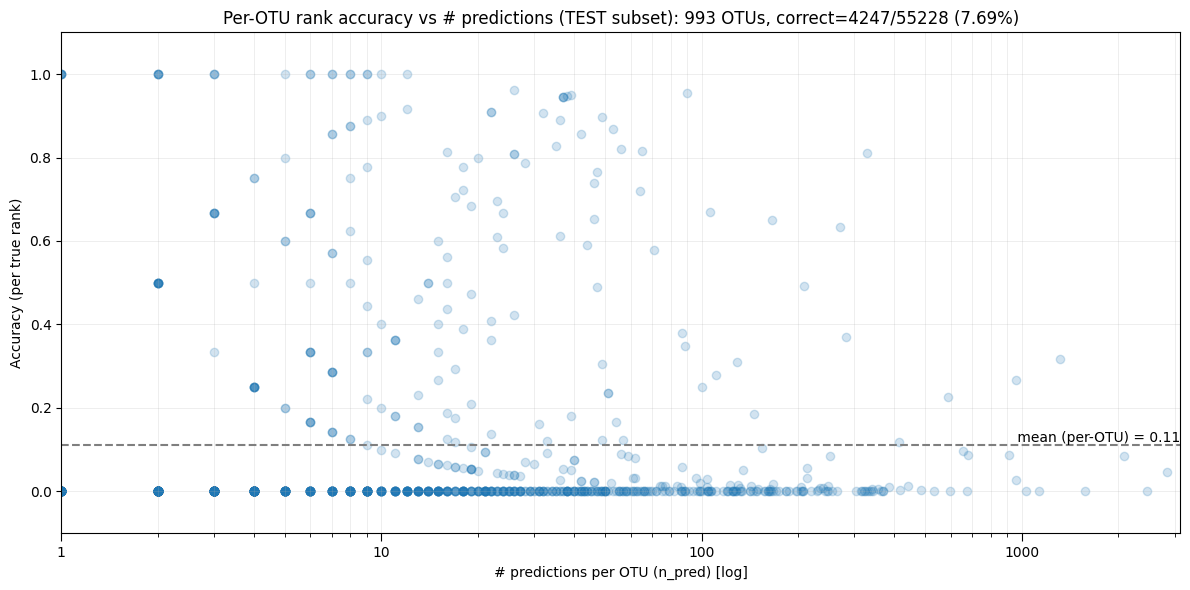

[INFO] multilabel eval: 15496 unique samples, 55228 predictions, 993 OTUs | correct=4247/55228 (7.69%)


In [27]:
df_raw, df_otu, summary, fig = evaluate_and_plot_predictions_multilabel(
    jsonl_path=OUT_JSONL_RANDOM,
    title_prefix="Per-OTU rank accuracy vs # predictions (TEST subset)"
)


# per level accuracy

In [30]:
from otu_taxa.dataloaders_unk_balanced import build_tax2ancestor_at_rank, build_tax2rank_from_vocab


In [31]:

RANKS = ("k","p","c","o","f","g","s")

# M_np must be the descendant closure used by the hierarchical loss: shape [T_base, T_base]
# tax_vocab_list must be length T_base (UNK-extended)
tax2rank = build_tax2rank_from_vocab(tax_vocab_unk)

ancestor_at_rank = {
    r: build_tax2ancestor_at_rank(
        M_np=M_np,                    # np.ndarray [T_base, T_base]
        tax_vocab_list=tax_vocab_unk,  # list[str] length T_base
        target_rank=r,
        missing_value=-1,
    )
    for r in RANKS
}

# quick sanity
for r in RANKS:
    assert len(ancestor_at_rank[r]) == M_np.shape[0]
print("[OK] built ancestor arrays for ranks:", RANKS)


[OK] built ancestor arrays for ranks: ('k', 'p', 'c', 'o', 'f', 'g', 's')


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Union, Tuple, Optional, Set, Dict, List

def plot_per_level_accuracy_hierarchical_from_arrays(
    jsonl_path: Union[str, Path],
    ancestor_at_rank: Dict[str, List[int]],   # rank -> dense list len T_base with ancestor_id or -1
    test_ids: Optional[Set[str]] = None,
    ranks=("k","p","c","o","f","g","s"),
    level_labels=None,
    otu_col: str = "otu_name",
    title: str = "Hierarchical model: per-level accuracy",
    make_plot: bool = True,
) -> Tuple[pd.DataFrame, pd.DataFrame, dict, Optional[plt.Figure]]:
    """
    Per-level accuracy for hierarchical predictions.

    For each row and each rank r:
      gold_r = ancestor_at_rank[r][true_tax_id]  (or -1 if missing)
      pred_r = pred_by_rank[r]["tax_id"]
      Compare pred_r vs gold_r only when gold_r != -1

    Returns:
      df (row-level), summary_df (rank-level), overall dict, fig
    """
    jsonl_path = Path(jsonl_path)
    df = pd.read_json(str(jsonl_path), lines=True)

    if level_labels is None:
        level_labels = {"k":"kingdom","p":"phylum","c":"class",
                        "o":"order","f":"family","g":"genus","s":"species"}

    # optional strict filtering
    if test_ids is not None and "sample_id" in df.columns:
        test_ids = set(map(str, test_ids))
        df["sample_id"] = df["sample_id"].astype(str)
        df = df[df["sample_id"].isin(test_ids)].copy()

    if df.empty:
        print("[WARN] No rows to evaluate after loading/filtering.")
        return df, pd.DataFrame(), {
            "n_samples": 0,
            "n_rows": 0,
            "micro_overall": float("nan"),
            "mean_macro_overall": float("nan"),
        }, None

    # ensure true_tax_id is int
    df["true_tax_id"] = df["true_tax_id"].astype(int)

    # extract pred_{r} columns from pred_by_rank
    for r in ranks:
        pred_col = f"pred_{r}"
        if pred_col not in df.columns:
            def _get_pred(d):
                if not isinstance(d, dict):
                    return None
                x = d.get(r, None)
                if not isinstance(x, dict):
                    return None
                try:
                    return int(x.get("tax_id"))
                except Exception:
                    return None
            df[pred_col] = df["pred_by_rank"].apply(_get_pred) if "pred_by_rank" in df.columns else None

    # gold_{r} from dense ancestor arrays
    for r in ranks:
        gold_col = f"gold_{r}"
        arr = ancestor_at_rank[r]
        df[gold_col] = df["true_tax_id"].apply(lambda t: arr[t] if (0 <= t < len(arr)) else -1)

    # compute micro & macro per rank
    def _metrics_at_rank(df_local: pd.DataFrame, r: str):
        pred_col = f"pred_{r}"
        gold_col = f"gold_{r}"

        # only rows where gold exists
        sub = df_local[df_local[gold_col] != -1].copy()
        if len(sub) == 0:
            return np.nan, np.nan, 0, 0

        pred_vals = sub[pred_col].fillna(-1).astype("int64").to_numpy()
        gold_vals = sub[gold_col].astype("int64").to_numpy()
        corr = (pred_vals == gold_vals)
        micro = float(corr.mean())

        # macro over OTUs
        def _per_otu_acc(s):
            idx = s.index
            s_pred = s.fillna(-1).astype("int64").to_numpy()
            s_gold = sub.loc[idx, gold_col].astype("int64").to_numpy()
            return float((s_pred == s_gold).mean())

        macro = float(sub.groupby(otu_col)[pred_col].apply(_per_otu_acc).mean())
        n_otus = int(sub[otu_col].nunique())
        n_rows = int(len(sub))
        return micro, macro, n_otus, n_rows

    micro_arr, macro_arr, otus_used, rows_used = [], [], [], []
    for r in ranks:
        m, M, n_otus, n_rows = _metrics_at_rank(df, r)
        micro_arr.append(m)
        macro_arr.append(M)
        otus_used.append(n_otus)
        rows_used.append(n_rows)

    overall = {
        "n_samples": int(df["sample_id"].nunique()) if "sample_id" in df.columns else None,
        "n_rows": int(len(df)),
        "micro_overall": float(np.nanmean(micro_arr)),
        "mean_macro_overall": float(np.nanmean(macro_arr)),
    }

    fig = None
    if make_plot:
        x = [level_labels[r] for r in ranks]
        fig, ax1 = plt.subplots(figsize=(9.5, 5))

        ax1.plot(x, micro_arr, marker="o", linewidth=2, label="Micro accuracy")
        ax1.plot(x, macro_arr, marker=".", linestyle="--", linewidth=2, label="Macro accuracy")

        for xi, yi in zip(x, macro_arr):
            if np.isfinite(yi):
                ax1.text(xi, yi + 0.03, f"{yi:.3f}", ha="center", va="bottom", fontsize=9)

        ax1.set_ylim(0.0, 1.02)
        ax1.set_ylabel("Accuracy")
        ax1.set_xlabel("Taxonomic level")
        ax1.set_title(title)
        ax1.grid(True, axis="y", alpha=0.3)

        ax2 = ax1.twinx()
        ax2.bar(x, otus_used, alpha=0.25, label="# OTUs")
        ax2.set_ylabel("Number of OTUs")

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

        plt.tight_layout()
        plt.show()

    summary_df = pd.DataFrame({
        "level": [level_labels[r] for r in ranks],
        "n_rows_used": rows_used,
        "n_otus_used": otus_used,
        "micro_acc": [round(v,4) if np.isfinite(v) else None for v in micro_arr],
        "macro_acc": [round(v,4) if np.isfinite(v) else None for v in macro_arr],
    })

    print(
        "[INFO] overall micro (avg over levels) = {:.3f}, mean macro (avg over levels) = {:.3f}".format(
            overall["micro_overall"], overall["mean_macro_overall"]
        )
    )

    return df, summary_df, overall, fig


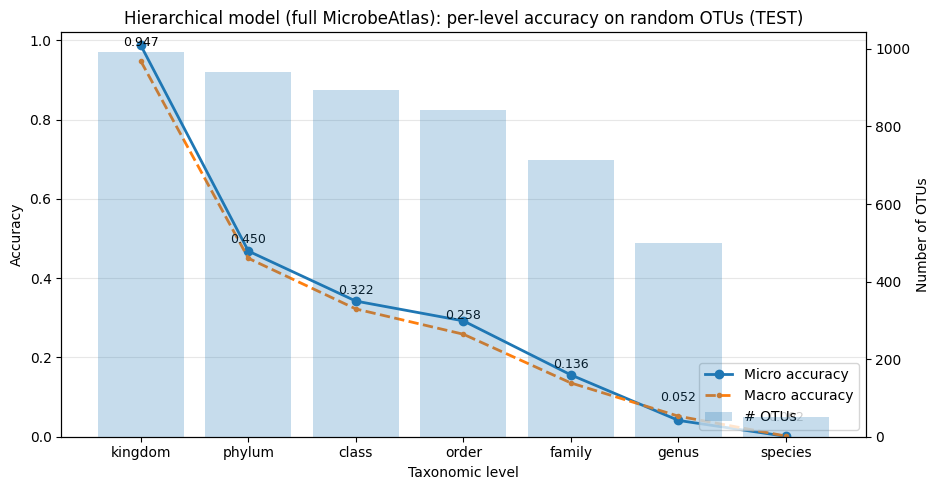

[INFO] overall micro (avg over levels) = 0.327, mean macro (avg over levels) = 0.310


,level,n_rows_used,n_otus_used,micro_acc,macro_acc
0,kingdom,55228,993,0.9869,0.9472
1,phylum,54740,941,0.4682,0.4501
2,class,53640,893,0.3421,0.3222
3,order,52387,843,0.2922,0.2585
4,family,47752,714,0.1558,0.1356
5,genus,37469,499,0.0411,0.0518
6,species,2262,52,0.0009,0.0016


In [33]:
JSONL_PER_RANK = OUT_JSONL_RANDOM  # your new predictions path

df_all, per_level_summary, overall, fig = plot_per_level_accuracy_hierarchical_from_arrays(
    jsonl_path=JSONL_PER_RANK,
    ancestor_at_rank=ancestor_at_rank,
    test_ids=None,  # optional; not needed if JSONL was generated strictly from test_ds
    ranks=("k","p","c","o","f","g","s"),
    title="Hierarchical model (full MicrobeAtlas): per-level accuracy on random OTUs (TEST)"
)

display(per_level_summary)


In [40]:
acc_table = build_accuracy_vs_rankACC_table(df, ranks=RANKS)

# nicer formatting
display(
    acc_table
    .assign(
        standard_accuracy=lambda x: x["standard_accuracy"].map(lambda v: f"{v:.4f}" if pd.notna(v) else "—"),
        rankACC=lambda x: x["rankACC"].map(lambda v: f"{v:.4f}" if pd.notna(v) else "—"),
    )
)


,standard_accuracy,rankACC,n_rows
k,0.2439,0.2439,488
p,0.0027,0.4977,1100
c,0.0128,0.3490,1253
o,0.2483,0.4637,4635
f,0.1505,0.4746,10283
g,0.0400,0.3923,35207
s,0.0009,0.2771,2262
Global,0.0769,0.4087,55228


In [34]:
from matplotlib.gridspec import GridSpec


RANKS = ("k","p","c","o","f","g","s")


# ------------------------------------------------------------
# 0) Build gold ancestor arrays 
# ------------------------------------------------------------
def build_ancestor_arrays_all_ranks(M_np, tax_vocab_unk, ranks=RANKS, missing_value=-1):
    """
    Returns dict rank -> dense list length T_base:
      ancestor_at_rank[r][t] = ancestor tax_id at rank r, else -1.
    """
    ancestor_at_rank = {}
    for r in ranks:
        ancestor_at_rank[r] = build_tax2ancestor_at_rank(
            M_np=M_np,
            tax_vocab_list=tax_vocab_unk,
            target_rank=r,
            missing_value=missing_value,
        )
    return ancestor_at_rank


# ------------------------------------------------------------
# 1) Load predictions + add pred_{r} + gold_{r}
# ------------------------------------------------------------
def load_predictions_with_pred_gold(
    jsonl_path,
    ancestor_at_rank,
    ranks=RANKS,
):
    df = pd.read_json(str(Path(jsonl_path)), lines=True)
    if df.empty:
        raise ValueError("Empty predictions file.")

    # ensure ints where needed
    df["true_tax_id"] = df["true_tax_id"].astype(int)

    # pred_{r} from pred_by_rank
    for r in ranks:
        pred_col = f"pred_{r}"
        if pred_col not in df.columns:
            def _get_pred(d):
                if not isinstance(d, dict):
                    return None
                x = d.get(r, None)
                if not isinstance(x, dict):
                    return None
                try:
                    return int(x.get("tax_id"))
                except Exception:
                    return None
            df[pred_col] = df["pred_by_rank"].apply(_get_pred) if "pred_by_rank" in df.columns else None

    # gold_{r} from dense arrays
    for r in ranks:
        gold_col = f"gold_{r}"
        arr = ancestor_at_rank[r]
        df[gold_col] = df["true_tax_id"].apply(lambda t: arr[t] if 0 <= t < len(arr) else -1)

    return df


# ------------------------------------------------------------
# 2) Correctness flags + deepest-rank + rankACC
# ------------------------------------------------------------
def _ensure_ok_columns(df, ranks=RANKS):
    """
    ok_{r} in {1.0, 0.0, NaN}:
      - NaN if gold_r missing (gold_r == -1)
      - 1.0 if pred_r == gold_r
      - 0.0 otherwise
    """
    df = df.copy()
    for r in ranks:
        pred = df[f"pred_{r}"]
        gold = df[f"gold_{r}"]

        has = (gold != -1)
        ok = pd.Series(np.nan, index=df.index, dtype="float")
        ok.loc[has] = (
            pred.loc[has].fillna(-1).astype("int64").to_numpy()
            ==
            gold.loc[has].fillna(-1).astype("int64").to_numpy()
        ).astype(float)

        df[f"ok_{r}"] = ok
    return df


def _deepest_gold_rank(row, ranks=RANKS):
    for r in reversed(ranks):
        if row.get(f"gold_{r}", -1) != -1:
            return r
    return None


def _first_wrong_rank_up_to_target(row, target_rank, ranks=RANKS):
    t_idx = ranks.index(target_rank)
    for r in ranks[: t_idx + 1]:
        if row[f"gold_{r}"] == -1:
            continue
        ok = row[f"ok_{r}"]  # 1.0/0.0/NaN
        if (not pd.isna(ok)) and (ok < 0.5):
            return r
    return None  # fully correct up to target


def _rankACC_for_row(row, target_rank, ranks=RANKS):
    """
    rankACC = m/D where D = index(target)+1, m = # consecutive correct from root until first error.
    Missing gold within k..target is skipped safely.
    """
    D = ranks.index(target_rank) + 1
    m = 0
    for r in ranks[:D]:
        if row[f"gold_{r}"] == -1:
            continue
        ok = row[f"ok_{r}"]
        if pd.isna(ok):
            continue
        if ok >= 0.5:
            m += 1
        else:
            break
    return float(m / max(1, D))


# ------------------------------------------------------------
# 3) Strict matrix + per-rank mean rankACC 
# ------------------------------------------------------------
def strict_error_origin_matrix_and_rankACC(df, ranks=RANKS):
    df2 = _ensure_ok_columns(df, ranks=ranks).copy()

    # deepest rank per row
    df2["deepest_rank"] = df2.apply(lambda row: _deepest_gold_rank(row, ranks=ranks), axis=1)
    df2 = df2[df2["deepest_rank"].notna()].copy()

    counts = pd.DataFrame(0, index=ranks, columns=ranks, dtype=int)
    meta_rows = []

    for target in ranks:
        sub = df2[df2["deepest_rank"] == target].copy()
        n_preds = int(len(sub))

        if n_preds == 0:
            meta_rows.append({
                "rank": target,
                "n_preds_strict": 0,
                "n_errors_strict": 0,
                "strict_error_rate": np.nan,
                "rankACC_mean": np.nan,
            })
            continue

        # rankACC per row
        sub["rankACC"] = sub.apply(lambda row: _rankACC_for_row(row, target, ranks=ranks), axis=1)
        rankACC_mean = float(sub["rankACC"].mean())

        # errors are rows not fully correct up to target
        err_mask = sub["rankACC"] < 0.999999
        errs = sub[err_mask].copy()
        n_errors = int(len(errs))

        if n_errors > 0:
            errs["first_wrong"] = errs.apply(
                lambda row: _first_wrong_rank_up_to_target(row, target, ranks=ranks),
                axis=1
            )
            vc = errs["first_wrong"].value_counts(dropna=True)
            for col_rank, cnt in vc.items():
                counts.loc[target, col_rank] = int(cnt)

        meta_rows.append({
            "rank": target,
            "n_preds_strict": n_preds,
            "n_errors_strict": n_errors,
            "strict_error_rate": float(n_errors / max(1, n_preds)),
            "rankACC_mean": rankACC_mean,
        })

    meta = pd.DataFrame(meta_rows).set_index("rank")
    return counts, meta


# ------------------------------------------------------------
# 4) Plot 
# ------------------------------------------------------------
def plot_strict_matrix_with_rankACC(
    counts_strict,
    meta_strict,
    title,
    ranks=RANKS,
    df=None,
    otu_col="otu_id",
    show_zeros_lower=True,
):
    ranks = list(ranks)

    mat = counts_strict.loc[ranks, ranks].fillna(0).astype(int)
    n_preds = meta_strict.loc[ranks, "n_preds_strict"].fillna(0).astype(int).to_numpy()
    rankacc = meta_strict.loc[ranks, "rankACC_mean"].to_numpy()
    rankacc = np.nan_to_num(rankacc, nan=0.0)

    extra = ""
    if df is not None:
        if otu_col in df.columns:
            n_otus = int(df[otu_col].nunique())
        elif "otu_name" in df.columns:
            n_otus = int(df["otu_name"].nunique())
        else:
            n_otus = None
        n_predictions = int(len(df))
        extra = f"OTUs={n_otus} | N predictions={n_predictions}" if n_otus is not None else f"N predictions={n_predictions}"

    fig = plt.figure(figsize=(10.0, 6.6))
    gs = GridSpec(
        2, 3,
        height_ratios=[0.75, 6.0],
        width_ratios=[20, 3.2, 1.1],
        hspace=0.06,
        wspace=0.08
    )

    # top denominators
    ax_top = fig.add_subplot(gs[0, 0])
    ax_top.bar(range(len(ranks)), n_preds, color="lightgray", edgecolor="none")
    ax_top.set_xlim(-0.5, len(ranks) - 0.5)
    ax_top.set_ylabel("# pred")
    ax_top.set_yticks([])
    ax_top.tick_params(axis="y", left=False, labelleft=False)
    ax_top.spines["left"].set_visible(False)
    ax_top.set_xticks([])
    ax_top.tick_params(axis="x", bottom=False, labelbottom=False)
    ax_top.spines["right"].set_visible(False)
    ax_top.spines["top"].set_visible(False)

    ymax = max(1, int(n_preds.max()) if len(n_preds) else 1)
    ax_top.set_ylim(0, ymax * 1.10)
    for i, n in enumerate(n_preds):
        ax_top.text(i, n + 0.01 * ymax, f"{n}", ha="center", va="bottom", fontsize=9)

    # heatmap
    ax_hm = fig.add_subplot(gs[1, 0], sharex=ax_top)
    data = mat.to_numpy()
    im = ax_hm.imshow(data, aspect="auto", cmap="Blues")

    ax_hm.set_xticks(range(len(ranks)))
    ax_hm.set_xticklabels(ranks)
    ax_hm.set_yticks(range(len(ranks)))
    ax_hm.set_yticklabels(ranks)
    ax_hm.set_xlabel("First wrong rank (error origin)")
    ax_hm.set_ylabel("Deepest labeled rank (strict rows)")

    vmax = int(data.max()) if data.size else 1
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            v = int(data[i, j])
            is_lower = (j <= i)
            if v > 0:
                ax_hm.text(
                    j, i, f"{v}",
                    ha="center", va="center", fontsize=8,
                    color="white" if v > 0.6 * vmax else "black",
                )
            elif show_zeros_lower and is_lower:
                ax_hm.text(j, i, "0", ha="center", va="center", fontsize=7, color="0.65")

    # rankACC bars
    ax_ra = fig.add_subplot(gs[1, 1], sharey=ax_hm)
    y = np.arange(len(ranks))
    ax_ra.barh(y, rankacc, color="lightgray", edgecolor="none")
    ax_ra.set_xlim(0.0, 1.0)
    ax_ra.set_xlabel("rankACC")
    ax_ra.tick_params(axis="y", left=False, labelleft=False)
    for i, v in enumerate(rankacc):
        ax_ra.text(0.03, i, f"{v*100:.1f}%", va="center", ha="left", fontsize=9, color="black")
    ax_ra.spines["top"].set_visible(False)
    ax_ra.spines["right"].set_visible(False)

    # colorbar
    ax_cb = fig.add_subplot(gs[1, 2])
    cbar = fig.colorbar(im, cax=ax_cb)
    cbar.set_label("Number of errors")

    fig.suptitle(f"{title}\n{extra}", y=0.985, fontsize=13, linespacing=1.3)
    return fig, (ax_top, ax_hm, ax_ra, ax_cb)


# ------------------------------------------------------------
# 5) Global rankACC (one scalar)
# ------------------------------------------------------------
def compute_global_rankACC(df, ranks=RANKS):
    df2 = _ensure_ok_columns(df, ranks=ranks).copy()
    df2["deepest_rank"] = df2.apply(lambda row: _deepest_gold_rank(row, ranks=ranks), axis=1)
    df2 = df2[df2["deepest_rank"].notna()].copy()

    df2["rankACC"] = df2.apply(lambda row: _rankACC_for_row(row, row["deepest_rank"], ranks=ranks), axis=1)
    return float(df2["rankACC"].mean()), df2


Global rankACC: 0.4087


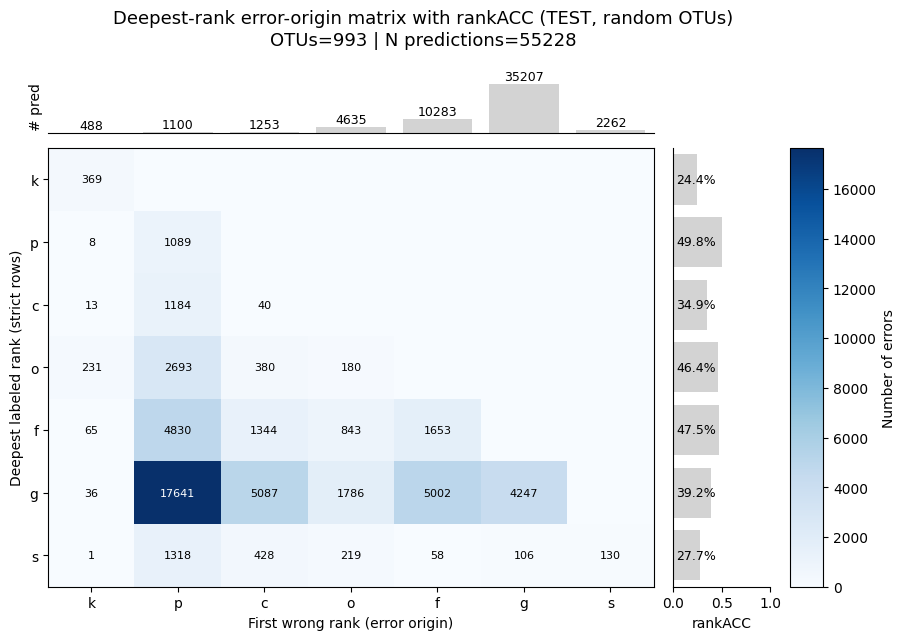

In [35]:
# 1) Build ancestor arrays from the same artifacts used by the new model
ancestor_at_rank = build_ancestor_arrays_all_ranks(
    M_np=M_np,                 # [T_base, T_base] np.ndarray
    tax_vocab_unk=tax_vocab_unk,
    ranks=RANKS,
    missing_value=-1,
)

# 2) Load predictions, add pred/gold columns
df = load_predictions_with_pred_gold(
    jsonl_path=OUT_JSONL_RANDOM,   # your JSONL path
    ancestor_at_rank=ancestor_at_rank,
    ranks=RANKS,
)

# 3) Strict matrix + meta for plot
counts_strict, meta_strict = strict_error_origin_matrix_and_rankACC(df, ranks=RANKS)

# 4) Plot
plot_strict_matrix_with_rankACC(
    counts_strict,
    meta_strict,
    title="Deepest-rank error-origin matrix with rankACC (TEST, random OTUs)",
    ranks=RANKS,
    df=df,
    otu_col="otu_id",   # or "otu_name" if your JSONL doesn’t have otu_id
    show_zeros_lower=True,
)

# 5) Global rankACC
global_rankACC, df_with_rankacc = compute_global_rankACC(df, ranks=RANKS)
print(f"Global rankACC: {global_rankACC:.4f}")


In [36]:
def plot_error_origin_matrix_rowpct_colored(
    counts,
    meta,
    title,
    ranks=RANKS,
    df=None,
    otu_col="otu_id",
    show_zeros_lower=True,
    show_percent_text: bool = True,     # annotate each cell with (row %)
    vmax_pct: float = 5.0,              # fixed scale upper bound in percentage points
    vmin_pct: float = 0.0,              # fixed scale lower bound
):
    ranks = list(ranks)

    # counts: errors per (deepest_rank=row, first_wrong=col)
    mat_counts = counts.loc[ranks, ranks].fillna(0).astype(int)
    data_counts = mat_counts.to_numpy()

    # denominators for row %: number of predictions whose deepest rank is that row
    n_preds = meta.loc[ranks, "n_preds_strict"].fillna(0).astype(int).to_numpy()

    # rankACC panel
    rankacc = meta.loc[ranks, "rankACC_mean"].to_numpy()
    rankacc = np.nan_to_num(rankacc, nan=0.0)

    # extra info line
    extra = ""
    if df is not None:
        if otu_col in df.columns:
            n_otus = int(df[otu_col].nunique())
        elif "otu_name" in df.columns:
            n_otus = int(df["otu_name"].nunique())
        else:
            n_otus = None
        n_predictions = int(len(df))
        extra = f"OTUs={n_otus} | N predictions={n_predictions}" if n_otus is not None else f"N predictions={n_predictions}"

    # -------------------------------------------------
    # Build the COLOR matrix: row-normalized percentage
    # pct[i,j] = 100 * count[i,j] / n_preds[i]
    # -------------------------------------------------
    data_pct = np.zeros_like(data_counts, dtype=float)
    for i in range(data_counts.shape[0]):
        denom = float(n_preds[i])
        if denom > 0:
            data_pct[i, :] = 100.0 * (data_counts[i, :] / denom)
        else:
            data_pct[i, :] = 0.0

    fig = plt.figure(figsize=(10.6, 6.8))
    gs = GridSpec(
        2, 3,
        height_ratios=[0.75, 6.0],
        width_ratios=[20, 3.2, 1.1],
        hspace=0.06,
        wspace=0.10
    )

    # -------------------------
    # Top denominators
    # -------------------------
    ax_top = fig.add_subplot(gs[0, 0])
    ax_top.bar(range(len(ranks)), n_preds, color="lightgray", edgecolor="none")
    ax_top.set_xlim(-0.5, len(ranks) - 0.5)
    ax_top.set_ylabel("# predictions")
    ax_top.set_yticks([])
    ax_top.tick_params(axis="y", left=False, labelleft=False)
    ax_top.spines["left"].set_visible(False)
    ax_top.set_xticks([])
    ax_top.tick_params(axis="x", bottom=False, labelbottom=False)
    ax_top.spines["right"].set_visible(False)
    ax_top.spines["top"].set_visible(False)

    ymax = max(1, int(n_preds.max()) if len(n_preds) else 1)
    ax_top.set_ylim(0, ymax * 1.12)
    for i, n in enumerate(n_preds):
        ax_top.text(i, n + 0.01 * ymax, f"{n}", ha="center", va="bottom", fontsize=9)

    # -------------------------
    # Heatmap colored by ROW %
    # -------------------------
    ax_hm = fig.add_subplot(gs[1, 0], sharex=ax_top)

    im = ax_hm.imshow(
        data_pct,
        aspect="auto",
        cmap="Blues",
        vmin=vmin_pct,
        vmax=vmax_pct,
    )

    ax_hm.set_xticks(range(len(ranks)))
    ax_hm.set_xticklabels(ranks)
    ax_hm.set_yticks(range(len(ranks)))
    ax_hm.set_yticklabels(ranks)

    ax_hm.set_xlabel("First incorrect prediction")
    ax_hm.set_ylabel("Deepest available label")

    # annotate: show counts and optionally row %
    for i in range(data_counts.shape[0]):
        for j in range(data_counts.shape[1]):
            v = int(data_counts[i, j])
            is_lower = (j <= i)

            if v > 0:
                pct = float(data_pct[i, j])
                if show_percent_text:
                    txt = f"{v}\n({pct:.2f}%)"
                else:
                    txt = f"{v}"

                # choose text color based on pct scale (not counts)
                txt_color = "white" if pct > 0.6 * vmax_pct else "black"

                ax_hm.text(
                    j, i, txt,
                    ha="center", va="center",
                    fontsize=8,
                    color=txt_color,
                    linespacing=0.9,
                )
            elif show_zeros_lower and is_lower:
                ax_hm.text(j, i, "0", ha="center", va="center", fontsize=7, color="0.65")

    # -------------------------
    # rankACC bars
    # -------------------------
    ax_ra = fig.add_subplot(gs[1, 1], sharey=ax_hm)
    y = np.arange(len(ranks))
    ax_ra.barh(y, rankacc, color="lightgray", edgecolor="none")
    ax_ra.set_xlim(0.0, 1.0)
    ax_ra.set_xlabel("rankACC")
    ax_ra.tick_params(axis="y", left=False, labelleft=False)
    for i, v in enumerate(rankacc):
        ax_ra.text(0.04, i, f"{v*100:.1f}%", va="center", ha="left", fontsize=9, color="black")
    ax_ra.spines["top"].set_visible(False)
    ax_ra.spines["right"].set_visible(False)

    # -------------------------
    # Colorbar (now in %)
    # -------------------------
    ax_cb = fig.add_subplot(gs[1, 2])
    cbar = fig.colorbar(im, cax=ax_cb)
    cbar.set_label("Error rate per row (%)")

    # Title
    #fig.suptitle(f"{title}\n{extra}", y=0.985, fontsize=13, linespacing=1.3)

    return fig, (ax_top, ax_hm, ax_ra, ax_cb)


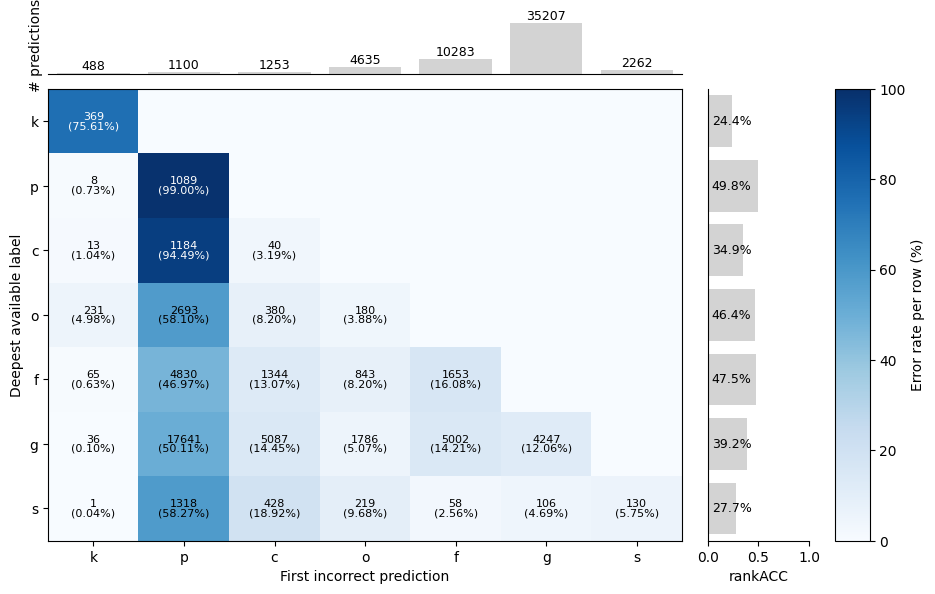

In [38]:
fig, axes = plot_error_origin_matrix_rowpct_colored(
    counts_strict,
    meta_strict,
    title= "",#"Deepest-rank error origin (TEST)",
    ranks=RANKS,
    df=df,
    otu_col="otu_id",
    show_zeros_lower=True,
    show_percent_text=True,  # keep the per-cell row %
    vmax_pct=100.0,            # fixed 0–5% scale for comparability
    vmin_pct=0.0,
)


In [39]:

RANKS = ("k","p","c","o","f","g","s")

def build_accuracy_vs_rankACC_table(df, ranks=RANKS):
    """
    Returns a DataFrame with:
      rows  : k, p, c, o, f, g, s, Global
      cols  : standard_accuracy, rankACC
    """

    # --------------------------------------------------
    # Ensure required columns exist
    # --------------------------------------------------
    df2 = _ensure_ok_columns(df, ranks=ranks).copy()

    if "deepest_rank" not in df2.columns:
        df2["deepest_rank"] = df2.apply(
            lambda row: _deepest_gold_rank(row, ranks=ranks), axis=1
        )

    # --------------------------------------------------
    # Per-rank metrics
    # --------------------------------------------------
    rows = []

    for r in ranks:
        # rows whose deepest available label is r
        sub = df2[df2["deepest_rank"] == r]

        if len(sub) == 0:
            rows.append({
                "rank": r,
                "standard_accuracy": np.nan,
                "rankACC": np.nan,
                "n_rows": 0,
            })
            continue

        # ---- standard accuracy at rank r (micro) ----
        ok_col = f"ok_{r}"
        valid = sub[ok_col].notna()

        if valid.any():
            standard_acc = float(sub.loc[valid, ok_col].mean())
        else:
            standard_acc = np.nan

        # ---- rankACC (same definition as your strict metric) ----
        sub_rankacc = sub.apply(
            lambda row: _rankACC_for_row(row, r, ranks=ranks), axis=1
        )
        rankacc_mean = float(sub_rankacc.mean())

        rows.append({
            "rank": r,
            "standard_accuracy": standard_acc,
            "rankACC": rankacc_mean,
            "n_rows": int(len(sub)),
        })

    per_rank_df = pd.DataFrame(rows).set_index("rank")

    # --------------------------------------------------
    # Global metrics
    # --------------------------------------------------
    global_rankACC, df_with_rankacc = compute_global_rankACC(df2, ranks=ranks)

    # global standard accuracy = exact match at deepest rank
    def _deepest_ok(row):
        r = row["deepest_rank"]
        if r is None:
            return np.nan
        return row.get(f"ok_{r}", np.nan)

    global_standard_acc = float(
        df2.apply(_deepest_ok, axis=1).dropna().mean()
    )

    global_row = pd.DataFrame(
        [{
            "standard_accuracy": global_standard_acc,
            "rankACC": global_rankACC,
            "n_rows": int(len(df2)),
        }],
        index=["Global"]
    )

    # --------------------------------------------------
    # Final table
    # --------------------------------------------------
    table = pd.concat([per_rank_df, global_row], axis=0)

    return table

acc_table = build_accuracy_vs_rankACC_table(df, ranks=RANKS)

# nicer formatting
display(
    acc_table
    .assign(
        standard_accuracy=lambda x: x["standard_accuracy"].map(lambda v: f"{v:.4f}" if pd.notna(v) else "—"),
        rankACC=lambda x: x["rankACC"].map(lambda v: f"{v:.4f}" if pd.notna(v) else "—"),
    )
)


,standard_accuracy,rankACC,n_rows
k,0.2439,0.2439,488
p,0.0027,0.4977,1100
c,0.0128,0.3490,1253
o,0.2483,0.4637,4635
f,0.1505,0.4746,10283
g,0.0400,0.3923,35207
s,0.0009,0.2771,2262
Global,0.0769,0.4087,55228
